## Chapter 3 Homework problem

In [1]:
%%javascript
require.config({
    paths: { 
        d3: 'https://d3js.org/d3.v5.min'
    }
});

<IPython.core.display.Javascript object>

In [2]:
from dag import draw_dag

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

## Problem 3.2.1

This problem had a lot of variables, and was kind of obnoxious, in my opinion. I am going to simplify the set of variables to actual numbers.

The problem was to look at the overall treatment effect, both by comparing the observed difference in taking drug vs not, and the _causal_ difference between taking the drug vs not.

We have the following DAG

In [4]:
draw_dag({'syndrome': ['treatment', 'outcome'], 'treatment': ['outcome']}, 
        positions = {'syndrome': [200, 50], 'treatment': [80, 150], 'outcome': [320, 150]})

<IPython.core.display.Javascript object>

Lets assign some probabilities.

We are going to try and generate a "Simpson's paradox", so that people more unlikely to recover will try and take the drug more, as there condition is more dire. We are going to be calculating the observed probability $P(\text{recovery}|\text{drug})$ and $P(\text{recovery}|\text{no drug})$, which are the probability _someone selected from the population at random recovers given that they did (or did not) take the drug, respectively_.

It is **not** the probability that someone selected at random and forced to take the drug (or not) would recover.

In [5]:
prob = {'syndrome': 0.4, 
        'drug_given_syndrome': 0.86, 
        'drug_given_no_syndrome': 0.1,
        'recover_given_drug_and_syndrome': 0.42,
        'recover_given_no_drug_and_syndrome': 0.05,
        'recover_given_drug_and_no_syndrome': 0.75,
        'recover_given_no_drug_and_no_syndrome': 0.56
       }

### Analytic approach (observed data)

This uses the fact that the DAG is telling us how the probability factorizes. Specifically

$$P(\text{syndrome, drug, outcome}) = P(\text{outcome} | \text{drug, syndrome})P(\text{drug} | \text{syndrome})P(\text{syndrome})$$

It may be easier to read this right to left (I write it this way to match Pearl): If we were simulating this, we would start with the syndrome, then determine the treatment (drug) as we need syndrome for input, and finally determine the outcome with the two inputs.

To put it another way, we can think of this as a probability tree:

1. Split on syndrome, P(syndrome)
2. Then split on drug, which is P(syndrome|drug) on the edges
3. Then split on recovery, which is P(recovery|drug, syndrome)

To find the total probability of the node P(syndrome, drug, outcome), multiply along the edges.


##### P(drug) [observed]
The probability of needing the drug is just conditional probability: P(A) = $\sum_{b\in B} P(A|B=b)P(B=b)$

In [6]:
prob_drug = (prob['drug_given_syndrome']*prob['syndrome'] +
             prob['drug_given_no_syndrome']*(1-prob['syndrome']))
prob_drug

0.404

In [7]:
prob_recover_given_drug = (
    prob['recover_given_drug_and_syndrome']*prob['drug_given_syndrome']*prob['syndrome'] +
    prob['recover_given_drug_and_no_syndrome']*prob['drug_given_no_syndrome']*(1-prob['syndrome']) 
                          )/prob_drug

In [8]:
prob_recover_given_drug

0.469009900990099

Carrying out the analogous calculation for not taking the drug:

In [9]:
prob_no_drug = 1 - prob_drug

prob_recover_given_no_drug = (
        prob['recover_given_no_drug_and_syndrome']*(1-prob['drug_given_syndrome'])*prob['syndrome'] +
        prob['recover_given_no_drug_and_no_syndrome']*(1-prob['drug_given_no_syndrome'])*(1-prob['syndrome'])
    ) / prob_no_drug

In [10]:
prob_recover_given_no_drug

0.5120805369127518

In [11]:
msg = f"""
i.e. we see that if we aggregate:
* {prob_recover_given_drug:.0%} recover given the drug, vs {prob_recover_given_no_drug:.0%} recover without a drug
"""
print(msg)


i.e. we see that if we aggregate:
* 47% recover given the drug, vs 51% recover without a drug



In [12]:
msg = f"""
If we condition on drug and syndrome, we have:
* Syndrome: {prob['recover_given_drug_and_syndrome']:.0%} recover with drug, vs {prob['recover_given_no_drug_and_syndrome']:.0%} without
* No syndrome: {prob['recover_given_drug_and_no_syndrome']:.0%} recover with drug, vs {prob['recover_given_no_drug_and_no_syndrome']:.0%} without
    """
print(msg)


If we condition on drug and syndrome, we have:
* Syndrome: 42% recover with drug, vs 5% without
* No syndrome: 75% recover with drug, vs 56% without
    


This is our simpson's reversal.

### Via simulation

What if I made an algebra error earlier in the calculation? A simulation is easier to reason about, and sets us up for simulating an intervention in the next section.

In [13]:
def simulate_outcome_single_person(prob):
    """Given the dictionary of probabilities, determines if this person
       recovers or not"""
    def returns_true_with_prob_p(p):
        return random.random() < p
    
    has_syndrome = returns_true_with_prob_p(prob['syndrome'])
    if has_syndrome:
        syndrome_string = 'syndrome'
        takes_drug = returns_true_with_prob_p(prob['drug_given_syndrome'])
    else:
        syndrome_string = 'no_syndrome'
        takes_drug = returns_true_with_prob_p(prob['drug_given_no_syndrome'])
    
    if takes_drug:
        drug_string='drug'
    else:
        drug_string = 'no_drug'

    recovers = returns_true_with_prob_p(prob[f'recover_given_{drug_string}_and_{syndrome_string}'])
    return dict(has_syndrome=has_syndrome, takes_drug=takes_drug, recovers=recovers)

simulate_outcome_single_person(prob)

{'has_syndrome': False, 'takes_drug': False, 'recovers': False}

In [14]:
def simulate_many_people(prob, N=10000):
    return pd.DataFrame([simulate_outcome_single_person(prob) for _ in range(N)])

experiment = simulate_many_people(prob)
experiment

,has_syndrome,takes_drug,recovers
0,True,True,False
1,False,False,True
2,False,False,False
3,False,False,True
4,False,False,True
...,...,...,...
9995,True,True,True
9996,False,False,True
9997,False,False,True
9998,True,True,True


Let's do our different groupby. First, only looking at the drug (not splitting by syndrome):

In [15]:
experiment.groupby('takes_drug').recovers.mean().reset_index()

,takes_drug,recovers
0,False,0.502759
1,True,0.476487


This is pretty close to the answers we saw above in the analytic section.

Now separating by syndrome:

In [16]:
experiment.groupby(['has_syndrome', 'takes_drug']).recovers.mean().reset_index().pivot(index='has_syndrome', columns='takes_drug')

recovers          
takes_drug       False     True 
has_syndrome                    
False         0.552656  0.756589
True          0.036332  0.422940

This also matches what we saw earlier.

## Simulation of "do" calculus

Let's calculate 
$$P(\text{recovery} | \text{do(drug)})$$
first. That is, what would it look like if everyone took the drug? In our simulation, we can just make `prob['drug_given_syndrome']` and `prob['drug_given_no_syndrome']` both equal to 1 (as we are trying to see what the effect of giving the drug would be)

In [17]:
prob_do_drug = {**prob,
                'drug_given_syndrome': 1,
                'drug_given_no_syndrome': 1}

In [18]:
experiment = simulate_many_people(prob_do_drug)
experiment

,has_syndrome,takes_drug,recovers
0,False,True,False
1,False,True,True
2,False,True,True
3,False,True,True
4,True,True,True
...,...,...,...
9995,False,True,False
9996,False,True,True
9997,False,True,True
9998,False,True,True


In this hypothetical world, how many people recover?

In [19]:
P_recover_DO_drug = experiment['recovers'].mean()
P_recover_DO_drug

0.6141

Now let's do the same thing for world where no one took the drug:

In [20]:
prob_do_no_drug = {**prob,
                'drug_given_syndrome': 0,
                'drug_given_no_syndrome': 0}
experiment = simulate_many_people(prob_do_no_drug)
experiment

,has_syndrome,takes_drug,recovers
0,True,False,False
1,False,False,True
2,True,False,False
3,True,False,False
4,False,False,False
...,...,...,...
9995,False,False,False
9996,True,False,False
9997,True,False,False
9998,False,False,False


In [21]:
P_recover_DO_no_drug = experiment['recovers'].mean()
P_recover_DO_no_drug

0.3615

The averge causal effect of the drug is the difference between these two quantities:

In [22]:
P_recover_DO_drug - P_recover_DO_no_drug

0.2526

i.e. About 27pp

### Using the Backdoor criterion to analytically get DO probabilities

Let's first think about this as a tree. Given the factorizaton, we think of our probabilities in a tree as

1. Split on syndrome, P(syndrome)
2. Then split on drug, which is P(drug|syndrome) on the edges
3. Then split on recovery, which is P(recovery|drug, syndrome)

What we really want to do is alter the probabilities in step 2 to be 1 for drug (irrespective of syndrome) and 0 for no_drug (irrespective of syndrome). The probabilities in the tree are telling us _how_ to generate the observed probabilities, so we can in fact use them. This is what we did in the simulation.

Let's do it that way, since we will observe all probabilites. Note this isn't using the BD formula directly, it is just using trees:

In [23]:
draw_dag({'.': ['S', 'NS'], 'S' :['D1', 'ND1'], 'D1': ['R11', 'NR11'], 'ND1':['R10', 'NR10'],
                            'NS':['D0', 'ND0'], 'D0': ['R01', 'NR01'], 'ND0':['R00', 'NR00']},
        positions = {'.': [50,200],
                     'S': [100, 100], 'NS': [100,300],
                     'D1': [200, 50], 'ND1': [200,150],
                     'D0': [200, 250], 'ND0': [200, 350],
                     'R11': [300, 25], 'NR11': [300, 80],
                     'R10': [300, 125], 'NR10': [300, 180],
                     'R01': [300, 225], 'NR01': [300, 275],
                     'R00': [300, 325], 'NR00': [300, 375]
                    })

<IPython.core.display.Javascript object>

We have all the conditional probabilities along this tree, we just want to modify them so that we have the probability of no drug (`ND*`) being 0, and probability of drug being 1. Putting aside the BD criteron and just doing is this way, we get

\begin{align*}
P(\text{recovery} | \text{do(drug)}) =& P(\text{syndrome})\times 1 \times P(\text{recovery} | \text{drug, syndrome})  &\\
& + 0 &\text{(No drug branch)}\\
& + P(\text{no syndrome})\times 1 \times P(\text{recovery} | \text{drug, no syndrome})&\\
& + 0 &\text{(No drug branch)}
\end{align*}

i.e. we replace $P(\text{drug}|*) = 1$ and $P(\text{no drug}|*) = 0$

Looking at the backdoor formula: first we check it applies. Delete the arrow from treatment to outcome, and we need to block syndrome. Then it tells us

$$P(\text{recover} | \text{do(drug)}) = \sum_{s\in\text{syndrome}}P(\text{recover}|\text{drug, s})P(s)$$

Writing this out in full:

\begin{align*}
P(\text{recover} | \text{do(drug)})&=  \sum_{s\in\text{syndrome}}P(\text{recover}|\text{drug, s})P(s)\\
  &=  P(\text{recover}|\text{drug, syndrome})P(\text{syndrome}) +  
      P(\text{recover}|\text{drug, no syndrome})P(\text{no syndrome})
\end{align*}

This is the same as the probability given by the trees!

In [24]:
P_recover_do_drug = (prob['recover_given_drug_and_syndrome']*prob['syndrome'] + 
                     prob['recover_given_drug_and_no_syndrome']*(1-prob['syndrome']))
P_recover_do_drug

0.618

Compare to the simulation result:


In [25]:
# from sim
P_recover_DO_drug

0.6141

Let's look at analytic result for P_recover_do_no_drug

In [26]:
P_recover_do_no_drug = (prob['recover_given_no_drug_and_syndrome']*prob['syndrome'] + 
                        prob['recover_given_no_drug_and_no_syndrome']*(1-prob['syndrome']))


msg=f"""
Analytic result for DO no drug: {P_recover_do_no_drug:.1%}
Simulation result for DO no drug: {P_recover_DO_no_drug:.1%}
"""
print(msg)


Analytic result for DO no drug: 35.6%
Simulation result for DO no drug: 36.1%



#### Conclusions:

* We saw a _risk difference_ P(recover|drug) - P(recover | no drug) = 0.47-0.51 = -0.04
* We saw a _average causal effect_ P(recover|do(drug)) - P(recover|do(no drug)) = 0.618 - 0.356 = 0.262

## 3.3.1: What to block?

This question wasn't terribly applied, but it was relatively straightforward. Given the DAG below, what do we need to block to get the effect of X on Y?

In [27]:
col0, col1, col2 = 100, 200, 300
row0, row1, row2 = 200, 300 ,400 

draw_dag({'B': ['A', 'Z'], 'C':['Z', 'D'],
          'A': ['X'], 'Z':['X', 'Y'], 'D': ['Y'],
          'X': ['W'], 'W': ['Y'], 'Y':[]},
         positions = {'B': [col0, row0], 'C': [col2, row0],
                      'A': [col0, row1], 'Z': [col1, row1], 'D': [col2, row1],
                      'X': [col0, row2], 'W': [col1, row2], 'Y': [col2, row2]})

<IPython.core.display.Javascript object>

a) What are all sets of variables that could be blocked?

Okay, we cannot ever block W, otherwise we cannot measure the direct path. Let's list all paths except `X -> W -> Y`, which is the one we want to measure:

1. `X <- A <- B -> Z <- C -> D -> Y`
2. `X <- A <- B -> Z -> Y`
3. `X <- Z <- C -> D -> Y`
4. `X <- Z -> Y`


* If we control for nothing, 1 is blocked (Z is a collider) but ....
* The only way of blocking 4 is to control $Z$ (which unblocks path 1), but automatically blocks paths 2 and 3

So we must control for $Z$, and then 3 and 4 are automatically blocked. So we just have to think about
1. `X <- A <- B -> Z <- C -> D -> Y`

We can block any non-empty subset of $\{A, B, C, D\}$ in addition to $Z$ to block this path. (This is sort of obnoxious, as there are 2^4 - 1 = 15 different subsets. 

I don't object to the problem, but I don't like just mindless enumeration at the end. The 15 possible sets to control are $\{Z\} \bigcup \{\text{any non empty subset of }A, B, C, D\}$

b) What are the minimal sets that block (i.e. a removal of any controlled variable no longer satisfies the BDC)

This is a much more reasonable question. We need Z and one of A, B, C, D. So the solutions are

1. A and Z
2. B and Z
3. C and Z 
4. D and Z

c) What are the minimal sets for measuring the effect of D on Y?

This one is actually interesting. One minimal set is control for C only (that blocks any backdoor path from $D$, as they all start `D <- C -> Z .......`, so controlling `C` blocks them all).

What if `C` cannot be controlled (e.g. it isn't measured)? The backdoor paths are
1. `D <- C -> Z -> Y` (must control on Z if we cannot control C)
2. `D <- C -> Z <- B -> A -> X -> W -> Y` (Z is a collider, but we control on it for path 1)
3. `D <- C -> Z -> X -> W -> Y`

To block path 1, we block Z, which automatically blocks path 3. So we only need to consider path 2:

`D <- C -> Z <- B -> A -> X -> W -> Y`

We can block this path by blocking A, B, X, or W.

So our minimal sets are

1. C only OR 
2. Z and one of A, B, X, or W

(I claim this is interesting because they are all "minimal sets" even though they are not all the same size)

## 3.3.2: Lord's paradox

We measure weights before and after a diet for two different diet plans. We see that plan B was more likely to be given to people with higher starting weights.

* Looking at weight changes of an individual, $\Delta w = w_f - w_i$, gives a distribution with a mean of 0
* Looking at fixed $w_i$, we can see on a plot of $w_f$ vs $w_i$ that the averages for plan B are higher


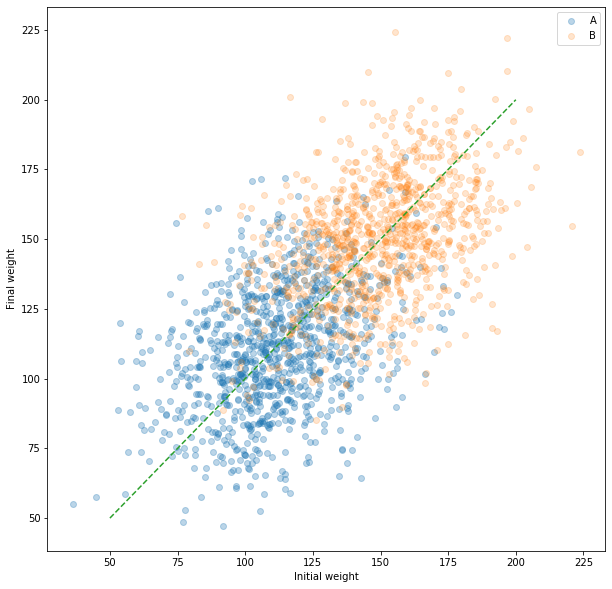

In [28]:
N = 1000
plt.figure(figsize=(10,10))
weight_A = np.random.multivariate_normal(mean=[110, 110], cov=[[500, 200],[200, 500]], size=N)
weight_A_i, weight_A_f = weight_A[:, 0], weight_A[:, 1]

weight_B = np.random.multivariate_normal(mean=[150, 150], cov=[[500, 200],[200, 500]], size=N)
weight_B_i, weight_B_f = weight_B[:, 0], weight_B[:, 1]

plt.plot(weight_A_i, weight_A_f, 'o', label='A', alpha=0.3)
plt.plot(weight_B_i, weight_B_f, 'o', label='B', alpha=0.2)
plt.xlabel('Initial weight')
plt.ylabel('Final weight')
plt.plot([50, 200], [50, 200], '--')
plt.legend()

In [29]:
weight_bin_A_mask = (weight_A_i >= 100) & (weight_A_i <= 115)
weight_bin_B_mask = (weight_B_i >= 100) & (weight_B_i <= 115)


# how do the mean final weights compare in a bin?
weight_A_f[weight_bin_A_mask].mean(), weight_B_f[weight_bin_B_mask].mean() 

(108.49995434950564, 132.5160431492544)

Note that weight B is significantly heavier. How about the weight gain of an individual?

In [30]:
(weight_A[:, 1] - weight_A[:, 0]).mean(), (weight_B[:, 1] - weight_B[:, 0]).mean(), 

(-0.7766601823223244, 0.9809772997043887)

Here the results are "close" to zero (and, depending on the run, it may even look like diet B made people lose weight). Should we bin by initial weight, or not?

It seems we used initial weight to determine which plan to put people in. So we have

In [31]:
draw_dag({'w_i': ['diet' , 'w_f'], 'diet': ['w_f']}, 
         positions={'w_i':[200, 40], 'w_f': [350, 200], 'diet':[50,200]})

<IPython.core.display.Javascript object>

This would tell us that we _should_ control for the initial weight, so the second statistician is correct, and looking at the differences in an individual without stratifying for initial weight is incorrect.

This was a surprising (countintuitive) conclusion, at least for me, but I found [a reference](https://m-clark.github.io/docs/lord/index.html) that backs it up.

## 3.3.3 Lollipop question

This question had to do with a slightly strange experiment. Basically we wanted to introduce something that seemed irrelevant (a lollipop) to a clinical trial, to see how it might break the analysis. Specifically:

- patients are randomly assigned a drug or placebo. Random tells us no incoming arrows to this.
- a nurse hands out lollipops to those who show signs of depression, and mostly among those that have been assigned the drug (the round took the nurse through the treatment ward)

The results of the experiment were:
- over the entire population, the drug was beneficial (vs placebo)
- among those that received lollipops, the drug group did worse
- among those that did not receive lollipops, the drug group did wose

a) If depression contributes to the disease, but lollipop consumption does not, draw a dag that describes this.

In [32]:
draw_dag({'treatment': ['lollipop', 'recovery'],
          'depression': ['lollipop', 'recovery']},
        positions={'treatment': [100, 50], 'lollipop': [200, 50], 'depression': [300, 50], 'recovery': [200,200]})

<IPython.core.display.Javascript object>

**b) What variables have to be controlled for?**

None! The only backdoor path is `treatment -> lollipop <- depression -> recovery`, and `lollipop` is a collider.

**c) The adjustment formula**

The adjustment formula uses the parents of X (or at least the version in 3.7 does) and the parents are the empty set. So we have P(recovery|do(treatment)) = P(recovery|treatment).

We can also get this from the backdoor criterion formula, where the set $Z$ of blocking variables is the empty set.

The intuition here is that because of the random assignment, we expect the contribution of depression to be the same to both the treated and non-treated groups; measuring the average difference in observed effect of treatment should match the average causal effect.

**d) repeat if lollipops are given post-treatment, with a preference of still giving people lollipops that were treated**

This question is actually ill-posed, it depends on how the drug works. I am also assuming that, like in the initial question, the nurse gives lollipops to those that are depressed at the time of distributing lollipops.

_Scenario 1: The drug works to alleviate the disease, but does so in ways other than alliviating depression._

The DAG is exactly the same as before, and the conclusions are the same.

_Scenario 2: One of the methods the drug uses to alleviate the disease is to reduce depression (so being less depressed gives us information on the efficancy of the treatment)__

The DAG looks very different. Let $d_i$ be depression at time of assignment, $d_f$ be depression post treatment. We have


In [33]:
draw_dag({'treatment': ['lollipop', 'recovery'],
          'd_i': ['recovery', 'd_f'],
          'recovery': ['d_f'],
          'd_f': ['lollipop']
         },
        positions={'treatment': [100, 50], 'lollipop': [100, 400], 'd_i': [300, 50], 'recovery': [200,200],
                   'd_f': [300, 400]})

<IPython.core.display.Javascript object>

Even in this case, if we control for nothing, the lollipop is still a collider. We should not control for the lollipop, in fact we should ignore it. Which makes sense -- it has no effect on the experiment, so it is a relief that everyone in the treatment group experiencing something that has no effect on the outcome is not something the experimenter needs to know about. Otherwise, you'd be concerned about "did a clown wander into the room of all the treated patients", etc

## Pharmacy problem

In [34]:
draw_dag({'severity': ['purchase', 'recovery'],
              'purchase': ['active'],
              'active': ['recovery']
             }, positions = {'severity': [200, 50], 'purchase': [30,200], 'active': [200,200],
                             'recovery': [430, 200]})

<IPython.core.display.Javascript object>

P(recovery | severe, drug) = 0.6


P(recovery | severe, no drug) = 0.5


P(recovery | mild, drug) = 0.8


P(recovery | mild, no drug) = 0.7

In [35]:
all_data = pd.DataFrame([
    {'S': 'High', 'cost': 'High', 'activity': 'High', 'recovery': 'Y', 'pop': 228},
    {'S': 'High', 'cost': 'High', 'activity': 'High', 'recovery': 'N', 'pop': 152},
    {'S': 'High', 'cost': 'High', 'activity': 'Low', 'recovery': 'Y', 'pop': 10},
    {'S': 'High', 'cost': 'High', 'activity': 'Low', 'recovery': 'N', 'pop': 10},
    {'S': 'High', 'cost': 'Low', 'activity': 'High', 'recovery': 'Y', 'pop': 3},
    {'S': 'High', 'cost': 'Low', 'activity': 'High', 'recovery': 'N', 'pop': 2},
    {'S': 'High', 'cost': 'Low', 'activity': 'Low', 'recovery': 'Y', 'pop': 47.5},
    {'S': 'High', 'cost': 'Low', 'activity': 'Low', 'recovery': 'N', 'pop': 47.5},
    {'S': 'Low', 'cost': 'High', 'activity': 'High', 'recovery': 'Y', 'pop': 76},
    {'S': 'Low', 'cost': 'High', 'activity': 'High', 'recovery': 'N', 'pop': 19},
    {'S': 'Low', 'cost': 'High', 'activity': 'Low', 'recovery': 'Y', 'pop': 3.5},
    {'S': 'Low', 'cost': 'High', 'activity': 'Low', 'recovery': 'N', 'pop': 1.5},
    {'S': 'Low', 'cost': 'Low', 'activity': 'High', 'recovery': 'Y', 'pop': 16},
    {'S': 'Low', 'cost': 'Low', 'activity': 'High', 'recovery': 'N', 'pop': 4},
    {'S': 'Low', 'cost': 'Low', 'activity': 'Low', 'recovery': 'Y', 'pop': 266},
    {'S': 'Low', 'cost': 'Low', 'activity': 'Low', 'recovery': 'N', 'pop': 114},
])
    
    

In [36]:
our_data = all_data.groupby(['cost', 'activity', 'recovery'], as_index=False).pop.sum()

In [37]:

our_data

,cost,activity,recovery,pop
0,High,High,N,171.0
1,High,High,Y,304.0
2,High,Low,N,11.5
3,High,Low,Y,13.5
4,Low,High,N,6.0
5,Low,High,Y,19.0
6,Low,Low,N,161.5
7,Low,Low,Y,313.5


In [38]:
our_data.groupby('cost').pop.sum()

cost
High    500.0
Low     500.0
Name: pop, dtype: float64

P(recovery | do(cost=high)) = \sum_activity P(activity|cost=high) (\sum_{costs x'} P(recovery|x', activity)P(x'))

                            = P(activity=High|cost=high) (P(recovery| cost=low, activity=High)P(cost=low) + 
                                                          P(recovery| cost=high, activity=High)P(cost=high)) +
                              P(activity=Low|cost=high)  (P(recovery| cost=low, activity=Low)P(cost=low) + 
                                                          P(recovery| cost=high, activity=Low)P(cost=high))

                            = (0.95) ((19/25) x 0.5 + 
                                      (304/475) x 0.5) +
                              (0.05) ((313.5/475) x 0.5 + 
                                      (13.5/25) x 0.5)

In [39]:
(0.95)*((19/25) + (304/475))*0.5 + (0.05)*0.5*((313.5/475) + 13.5/25)

0.695

P(recovery | do(cost=low)) = \sum_activity P(activity|cost=low) (\sum_{costs x'} P(recovery|x', activity)P(x'))

                            = P(activity=High|cost=low) (P(recovery| cost=low, activity=High)P(cost=low) + 
                                                          P(recovery| cost=high, activity=High)P(cost=high)) +
                              P(activity=Low|cost=low)  (P(recovery| cost=low, activity=Low)P(cost=low) + 
                                                          P(recovery| cost=high, activity=Low)P(cost=high))

In [40]:
(0.05)*((19/25) + (304/475))*0.5 + (0.95)*0.5*((313.5/475) + 13.5/25)

0.6050000000000001